In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import torch.nn as nn

device = "cuda:2" if torch.cuda.is_available() else "cpu"

In [2]:
import sys 
sys.path.append('..')


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

testset = torchvision.datasets.ImageFolder('../texture_vs_shape/stimuli/style-transfer-preprocessed-512', transform=test_transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False,  pin_memory=True, num_workers=16)

In [3]:
image_names = [testloader.dataset.imgs[i][0].rsplit('/', 1)[-1] for i in range(len(testloader.dataset.imgs))]

print(image_names)
print(len(testloader.dataset.imgs))

['airplane1-bicycle2.png', 'airplane1-chair2.png', 'airplane1-clock1.png', 'airplane1-elephant1.png', 'airplane10-airplane1.png', 'airplane10-bear3.png', 'airplane10-boat3.png', 'airplane10-car3.png', 'airplane10-cat2.png', 'airplane10-dog3.png', 'airplane10-elephant1.png', 'airplane10-knife3.png', 'airplane10-oven2.png', 'airplane10-truck1.png', 'airplane2-bear1.png', 'airplane2-bicycle1.png', 'airplane2-bird3.png', 'airplane2-bottle1.png', 'airplane2-cat1.png', 'airplane2-dog1.png', 'airplane3-airplane2.png', 'airplane3-car1.png', 'airplane3-cat1.png', 'airplane3-chair3.png', 'airplane3-clock1.png', 'airplane3-dog1.png', 'airplane3-elephant1.png', 'airplane3-keyboard2.png', 'airplane3-oven1.png', 'airplane4-airplane1.png', 'airplane4-bear3.png', 'airplane4-bicycle2.png', 'airplane4-bird3.png', 'airplane4-boat3.png', 'airplane4-bottle1.png', 'airplane4-car1.png', 'airplane4-cat3.png', 'airplane4-dog2.png', 'airplane4-elephant1.png', 'airplane4-keyboard3.png', 'airplane4-knife1.png', '

In [4]:
image_indices_to_ignore=[]
image_indices_to_keep=[]
diff_shape_texture=[]
    
substring_list=sorted(["knife", "keyboard", "elephant", "bicycle", "airplane",
            "clock", "oven", "chair", "bear", "boat", "cat",
            "bottle", "truck", "car", "bird", "dog"])
for i in range(len(image_names)):
    matches = [x for x in substring_list if x in image_names[i]]
    if len(matches)==1:
        image_indices_to_ignore.append(i)
    elif len(matches)==2:
        image_indices_to_keep.append(i)
        diff_shape_texture.append(matches)
        
        
print(image_indices_to_ignore)
print(diff_shape_texture)
print(len(diff_shape_texture))

[4, 20, 29, 56, 72, 81, 87, 132, 140, 147, 162, 178, 191, 212, 218, 253, 259, 265, 281, 296, 330, 350, 359, 374, 393, 414, 425, 451, 467, 473, 481, 489, 495, 512, 537, 564, 581, 587, 594, 634, 643, 670, 695, 705, 716, 723, 732, 740, 764, 773, 807, 814, 823, 829, 869, 890, 900, 921, 949, 959, 971, 990, 1001, 1027, 1038, 1055, 1070, 1078, 1085, 1096, 1130, 1140, 1176, 1185, 1199, 1214, 1250, 1260, 1268, 1279]
[['airplane', 'bicycle'], ['airplane', 'chair'], ['airplane', 'clock'], ['airplane', 'elephant'], ['airplane', 'bear'], ['airplane', 'boat'], ['airplane', 'car'], ['airplane', 'cat'], ['airplane', 'dog'], ['airplane', 'elephant'], ['airplane', 'knife'], ['airplane', 'oven'], ['airplane', 'truck'], ['airplane', 'bear'], ['airplane', 'bicycle'], ['airplane', 'bird'], ['airplane', 'bottle'], ['airplane', 'cat'], ['airplane', 'dog'], ['airplane', 'car'], ['airplane', 'cat'], ['airplane', 'chair'], ['airplane', 'clock'], ['airplane', 'dog'], ['airplane', 'elephant'], ['airplane', 'keyboa

In [5]:
import sys 
sys.path.append("../texture_vs_shape/code")
import probabilities_to_decision

def get_shape_bias(net):
    correct_shape=0
    correct_texture=0
    
#     c_shape=[]
#     c_texture=[]
#     softmax=nn.Softmax(0)
    decision_from_16_classes = []
    
    with torch.no_grad():
        torch.cuda.empty_cache()
        for batch_idx, (data, target) in enumerate(testloader):

            data, target = data.to(device), target.to(device)

            output = net(data)

            # get softmax output
            softmax_output = F.softmax(output, 1) # replace with your favourite CNN
            #print(softmax_output)

            # convert to numpy
            softmax_output_numpy = softmax_output.to('cpu').numpy() # replace with conversion

            torch.cuda.empty_cache()
            
            # create mapping
            mapping = probabilities_to_decision.ImageNetProbabilitiesTo16ClassesMapping()

            for i in range(data.shape[0]):
                decision_from_16_classes.append(mapping.probabilities_to_decision(softmax_output_numpy[i]))

        #print("Decision:")
        #print(len(decision_from_16_classes))
        #print(decision_from_16_classes)

        #=print(len(image_indices_to_keep))
        decision_from_16_classes_TOKEEP = [decision_from_16_classes[i] for i in image_indices_to_keep]
        #print("#Images with a cue conflict e.g. texture=cat, shape=cat : ", len(decision_from_16_classes_TOKEEP))

        for i in range(len(decision_from_16_classes_TOKEEP)):
            if decision_from_16_classes_TOKEEP[i]==diff_shape_texture[i][0]:
                correct_shape+=1
#                 c_shape.append(i)
            if decision_from_16_classes_TOKEEP[i]==diff_shape_texture[i][1]:
                correct_texture+=1
#                 c_texture.append(i)

        shape_bias=correct_shape/(correct_shape+correct_texture)
    
        torch.cuda.empty_cache()
        return shape_bias

In [6]:
n_bns = [1, 2, 4, 8, 16, 32]
reps = [0, 1]

results={'Bottleneck Size':[], 'Run':[], 'Shape Bias':[]}

for n_bn in n_bns:
    for rep in reps:
            print("-"*80)
            print(n_bn, rep)
            print("-"*80)
            model = torch.hub.load('ecs-vlc/bottleneck:master', 'imagenet_resnet50', n_bn=n_bn, rep=rep, verbose=False)
            model.eval()
            model.to(device)

            shape_bias = get_shape_bias(model)

            print('Stylized-ImageNet Shape Bias (%):', round(100*shape_bias, 4))
            print()
            results['Bottleneck Size'].append(n_bn)
            results['Run'].append(rep)
            results['Shape Bias'].append(shape_bias)

--------------------------------------------------------------------------------
1 0
--------------------------------------------------------------------------------
Stylized-ImageNet Shape Bias (%): 46.0927

--------------------------------------------------------------------------------
1 1
--------------------------------------------------------------------------------
Stylized-ImageNet Shape Bias (%): 46.5894

--------------------------------------------------------------------------------
2 0
--------------------------------------------------------------------------------
Stylized-ImageNet Shape Bias (%): 49.7549

--------------------------------------------------------------------------------
2 1
--------------------------------------------------------------------------------
Stylized-ImageNet Shape Bias (%): 47.2542

--------------------------------------------------------------------------------
4 0
-------------------------------------------------------------------------------

Text(0.5, 1.0, 'Stylized-ImageNet Shape Bias')

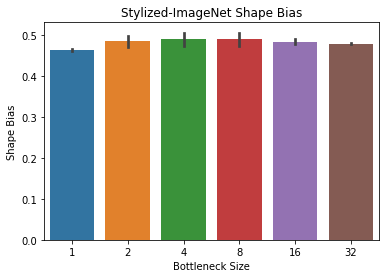

In [9]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame.from_dict(results)
# print(data)
sns.barplot(x="Bottleneck Size", y="Shape Bias", data=data).set_title("Stylized-ImageNet Shape Bias")

In [8]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)

resnet50.eval()
resnet50.to(device)

shape_bias = get_shape_bias(resnet50)

print('ResNet50 Shape Bias (%):', round(100*shape_bias, 4))
print()

ResNet50 Shape Bias (%): 49.7519

